In [1]:
import numpy as np
import lmdb
import sys
caffe_root = '..'
sys.path.insert(0,caffe_root+'/python')
import caffe
import os
import cv2
from scipy import misc
from os.path import expanduser
home_dir = expanduser("~")
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from pycocotools.coco import COCO
from PIL import Image

In [2]:
annType = ['segm','bbox']
annType = annType[0]      #specify type here
dataDir=home_dir + '/data/coco'
dataType='train2014'

In [3]:
caffe.set_device(4)
caffe.set_mode_gpu()

In [4]:
with open(dataDir+'/test_img.lst','r') as f:
    test_img_lst = f.readlines() 
with open(dataDir+'/test_label.lst','r') as f:
    test_label_lst = f.readlines() 

In [8]:
test_img_num = 500
step = 2000
start = 10000
end = 30001
val_loss = np.zeros((test_img_num,len(np.arange(start, end, step))))

[10000 12000 14000 16000 18000 20000 22000 24000 26000 28000 30000]
185816.387984 185797.915844


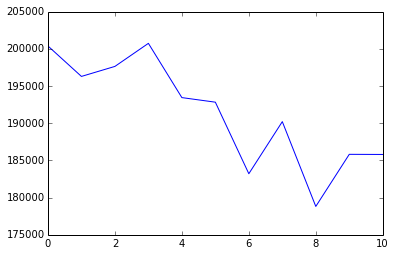

In [24]:
print np.arange(start, end, step)
plt.plot(np.mean(val_loss,axis=0))
print np.mean(val_loss[:,9],axis=0), np.mean(val_loss[:,10],axis=0)

In [ ]:
for itr in np.arange(start, end, step):
# for itr in [26000]:
    k = (itr-start)/step
    net = caffe.Net(caffe_root+'/models/coco-baseline/deploy.prototxt',caffe_root+'/models/coco-baseline/base_'+str(itr)+'.caffemodel',caffe.TEST)
    for i in range(0, len(test_img_lst)):
        im = Image.open(test_img_lst[i][:-1])
        label = Image.open(test_label_lst[i][:-1])
        label = np.array(label, dtype=np.float32)
        im = np.array(im, dtype=np.float32)
        if im.ndim==2:
            im = np.expand_dims(im,axis=2)
            im = np.tile(im, (1,1,3))
        im = im[:,:,::-1]
        im -= np.array((104.00698793,116.66876762,122.67891434))
        im = im.transpose((2,0,1))
        im = np.expand_dims(im,axis=0)
        label = np.expand_dims(label,axis=0)
        label = np.expand_dims(label,axis=0)
        net.blobs['data'].reshape(*im.shape)
        net.blobs['data'].data[...] = im
        net.blobs['label'].reshape(*label.shape)
        net.blobs['label'].data[...] = label
        net.forward()
        val_loss[i,k] = net.blobs['loss'].data
    np.save(caffe_root+'/models/coco-baseline/val_loss.npy',val_loss)

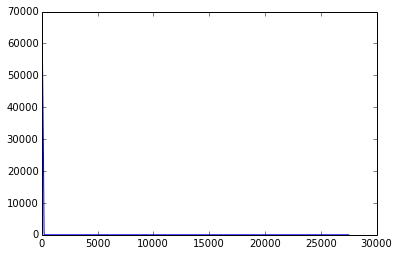

In [9]:
train_loss = np.load('../models/coco-baseline/train_loss.npy')
def moving_average(a, n=500) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
plt.plot(moving_average(train_loss[0:28000]))

In [27]:
annFile = '%s/annotations/instances_%s.json'%(dataDir,dataType)
cocoGt=COCO(annFile)

loading annotations into memory...
Done (t=24.31s)
creating index...
index created!


In [30]:
imgIds = cocoGt.getImgIds()
for imgId in imgIds:
    img = cocoGt.loadImgs(ids=imgId)
    img = img[0]
    im = Image.open(dataDir + '/images/'+dataType+'/'+img['file_name'])
    im = np.array(im,dtype=np.float32)
    imglength = np.max(im.shape)
    scale_factor = 640/float(imglength)
    im = cv2.resize(im,None,fx=scale_factor,fy=scale_factor) 
    im = Image.fromarray((im).astype(np.uint8))
    im.save(dataDir + '/images-resized/'+dataType+'/'+img['file_name'])

AttributeError: __float__

In [15]:
imgIds = cocoGt.getImgIds()
np.random.shuffle(imgIds)
imgIds = imgIds[0:500]
with open(dataDir+'/test_img.lst','w') as f:
    for imgId in imgIds:
        img = cocoGt.loadImgs(ids=imgId)
        img = img[0]
        imgPath = dataDir + '/images/'+dataType+'/'+img['file_name']
        f.write(imgPath+'\n')
with open(dataDir+'/test_label.lst','w') as f:
    for imgId in imgIds:
        img = cocoGt.loadImgs(ids=imgId)
        img = img[0]
        labelPath = dataDir + '/preprocessed/labelmap/'+dataType+'/'+img['file_name'][:-3]+'png'
        f.write(labelPath+'\n')      
